# Vision based classification

In deze notebook zullen we gebruik maken van vision based classification. Het idee van vision based classification is om informatie uit de afbeelding te verzamelen. Deze data wordt dan gebruikt om de afbeelding te classificeren.

# Uitvoering

Om dit probleem op te pakken zullen we de workflow hanteren die voornamelijk worden gebruikt binnen een Machine learning probleem (Data Science lifecycle). De workflow is te verdelen in de volgende stappen:

1. Data verzamelen
2. Data analyseren
3. Preprocessen
4. Feature engineering
5. Trainen / Testen / Evalueren

Allereerst beginnen we met het importeren van de libraries die we nodig zullen hebben in onze code.

In [4]:
import cv2
import os
import numpy as np
import skimage
from skimage import io, transform, color, filters, data, morphology, measure
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def load_images_from_folder(folder):
    images = []
    images_name = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            images_name.append(filename[0:4])
    
    images_df = pd.DataFrame({"name": images_name,
                             "image": images})
    #print(images_df)
    return images_df

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    
    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

De hierboven gedefineerde functies zijn geleverd door Saxion zelf. Die zullen gebruikt worden voor het inladen van de data en het tonen van de afbeeldingen.

Hieronden wordt de data ingeladen. Voor de zekerheid zullen we de data ook printen.

In [5]:
all_images_df = load_images_from_folder('../dataset-images/dataset1')
all_images_df

,name,image
0,1000,"[[[241, 241, 241], [242, 242, 242], [244, 244,..."
1,1027,"[[[206, 206, 206], [211, 211, 211], [218, 218,..."
2,1029,"[[[82, 82, 82], [83, 83, 83], [84, 84, 84], [8..."
3,1036,"[[[241, 241, 241], [246, 246, 246], [243, 243,..."
4,1053,"[[[241, 241, 241], [243, 243, 243], [243, 243,..."
...,...,...
235,5264,"[[[228, 228, 228], [227, 227, 227], [224, 224,..."
236,5339,"[[[70, 70, 70], [71, 71, 71], [67, 67, 67], [7..."
237,5377,"[[[243, 243, 243], [236, 236, 236], [243, 243,..."
238,5382,"[[[214, 214, 214], [222, 222, 222], [206, 206,..."


Zoals hierboven is te zien is de data succesvol geladen. Laten we voor de zekerheid kijken of er toch geen gebreken zijn. Hiervoor zullen we de "describe()" functie gebruiken.

In [6]:
all_images_df.describe()

,name,image
count,240,240
unique,240,240
top,1929,"[[[222, 222, 222], [240, 240, 240], [238, 238,..."
freq,1,1


Voor nu lijkt de data in orde dus kunnen we verder gaan.

De data is nu verzameld.

Om de data te kunnen gebruiken voor de machine learning algoritme zullen we het eerst moeten preprocessen en de features eruit halen.

Hieronder zullen we een begin maken met het schrijven van de eerste versie van de preproces pipeline. Hiervoor zullen we de volgende stappen uitvoeren:

1. eerst beschrijven we een lijst met afbeelding eigenschappen die we willen verzamelen.
2. De kleuren van de afbeelding omdraaien, zodat de cijfers wit zijn en de achtergrond zwart.
3. De afbeelding omzetten naar een binair formaat (zwart/wit).
4. De afbeeldijng bewerken/verfijnen zodat we de eigenschappen beter kunnen uitlezen (morphology operaties).
5. Eigenschappen uit de afbeelding halen.

In de code zijn de stappen dieper uitgelegd, waarom een bepaalde functie gebruikt wordt.

In [9]:
df = None
error_counts = 0

image_properties = ['label','area', 'bbox', 'bbox_area', 'centroid', 'perimeter', 
            'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
            'extent', 'feret_diameter_max', 'filled_area',
            'perimeter_crofton', 'solidity', 'local_centroid', 'major_axis_length',
            'minor_axis_length', 'moments_hu', 'orientation']

# 'moments_hu', 'orientation' 'euler_number',

def initialize_image(image, image_name):
    zipcode = image
    zipcode = zipcode *-1
    gray = color.rgb2gray(zipcode)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    #display(binary)
    
    # remove the white small spots/dots
    binary = morphology.binary_opening(binary)
    #display(binary)
    
    # make the white zip numbers thicker
    binary = morphology.binary_dilation(binary)
    #display(binary)
    
    # some numbers may have holes in it. That could seperate the number in 2 different labels. with closing the gap will be closed
    binary = morphology.binary_closing(binary)
    #display(binary)
    
    # return number back to its original state before it was made thicker. make the numbers thinner
    binary = morphology.binary_erosion(binary)
    #display(binary)
    # return_num=True, connectivity=None
    #print(binary)
    label_image, total_labels = measure.label(binary, return_num=True)
    #display(label_image)
    global image_properties
    props = measure.regionprops_table(label_image, properties=image_properties)
    tmp_df = pd.DataFrame(props)
    
    # filter out labels that have too small areas. these labels are small dots that could not be filled with the opening function
    tmp_df = tmp_df.query('area > 50')
    zip_numbers = list(image_name)[:4]
    
    if len(tmp_df.index) == 4:
        tmp_df.insert(0, 'zip_numbers', zip_numbers)
    else:
        return None
        
    return tmp_df

print('----------done---------')

----------done---------


In [10]:
result = pd.DataFrame()

for i in range(0, len(all_images_df.index)):
    image_name = all_images_df.iloc[i,0]
    image = all_images_df.iloc[i,1]
    tmp_result = initialize_image(image, image_name)
    result = pd.concat([result, tmp_result])

result.reset_index(inplace=True)
result.drop(columns=['index', 'label'], inplace=True)
result

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
0,1,287,0,6,32,26,640,15.310105,17.933798,89.840620,...,30.408628,17.616293,0.268950,0.017899,0.013183,0.000420,-2.683356e-07,-0.000042,-9.497167e-07,-0.049638
1,0,296,0,38,32,58,640,16.425676,47.395270,143.781746,...,37.565785,23.184497,0.411467,0.034031,0.001471,0.000066,-1.990600e-08,-0.000005,5.877535e-09,0.046295
2,0,300,0,70,32,91,672,16.080000,79.313333,145.781746,...,38.187484,23.086854,0.414851,0.037159,0.000701,0.000134,1.355049e-08,-0.000022,-3.859056e-08,0.131159
3,0,346,0,101,32,123,704,15.502890,111.341040,151.781746,...,38.646650,25.671956,0.388839,0.022724,0.000076,0.000091,-9.519663e-10,0.000008,7.537652e-09,0.109576
4,1,318,0,4,32,29,800,18.584906,14.393082,103.840620,...,40.612946,15.840432,0.373493,0.075548,0.010167,0.001006,-6.020065e-07,-0.000052,3.158651e-06,0.378889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,345,0,102,32,124,704,17.214493,111.115942,120.225397,...,42.337704,18.416269,0.386167,0.069318,0.004804,0.000744,1.386400e-06,0.000195,-2.293072e-07,0.156394
956,5,279,0,7,32,24,544,14.326165,14.627240,109.396970,...,41.787009,14.656867,0.439287,0.117676,0.004865,0.001923,5.867712e-06,0.000648,4.255932e-07,0.038346
957,3,312,0,38,32,59,672,15.310897,48.391026,122.953319,...,40.042129,17.197767,0.380436,0.068613,0.003335,0.000618,-5.978847e-07,-0.000150,6.565419e-07,0.134856
958,8,431,0,69,32,92,736,16.447796,78.846868,150.994949,...,34.289232,21.607479,0.238201,0.010567,0.000232,0.000038,1.728684e-09,0.000004,3.095958e-09,0.125511


Deze stappen leveren uiteindelijk de features op die hierboven te zien zijn. Laten we eerst controleren of er gebreken zijn ontstaan in de data. dit doen we door middel van de "describe()" functie.

In [12]:
result['zip_numbers'] = result['zip_numbers'].astype(int)
result.describe(include="all")

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,...,960.000000,960.000000,960.000000,960.000000,9.600000e+02,960.000000,9.600000e+02,960.000000,9.600000e+02,960.000000
mean,3.942708,332.423958,0.003125,54.134375,31.995833,74.677083,657.215625,15.576430,63.847869,117.157728,...,36.444834,18.249425,0.320020,0.040553,4.261452e-03,0.000988,4.006409e-06,0.000127,6.496319e-07,0.058086
std,2.741914,38.525623,0.055843,35.924897,0.064449,35.901933,75.798099,1.646801,35.806607,17.325586,...,3.580145,2.538358,0.062327,0.025356,5.194869e-03,0.001379,1.541752e-05,0.000330,1.032642e-05,0.167079
min,0.000000,203.000000,0.000000,1.000000,31.000000,20.000000,352.000000,11.506623,12.000000,81.254834,...,28.065655,8.955324,0.188338,0.003217,1.436339e-07,0.000002,-1.409764e-05,-0.000624,-2.424378e-04,-0.614621
25%,2.000000,301.000000,0.000000,27.250000,32.000000,47.750000,620.000000,14.560205,38.347485,105.296465,...,34.222018,16.727510,0.272610,0.021886,8.010861e-04,0.000156,-7.362563e-11,-0.000001,-4.219631e-08,-0.039348
50%,4.000000,333.000000,0.000000,54.000000,32.000000,74.500000,640.000000,15.433922,64.276136,116.778698,...,36.736923,18.214579,0.315562,0.034587,2.506564e-03,0.000477,1.452694e-07,0.000022,8.823401e-09,0.071319
75%,6.000000,359.000000,0.000000,81.000000,32.000000,101.250000,704.000000,16.529212,89.409466,129.231493,...,39.326080,19.800529,0.359501,0.055210,6.194887e-03,0.001226,1.819173e-06,0.000135,6.465412e-07,0.164588
max,9.000000,446.000000,1.000000,106.000000,32.000000,128.000000,960.000000,20.266667,116.496894,167.480231,...,43.520157,26.083379,0.578771,0.203847,5.461427e-02,0.012590,2.240915e-04,0.002822,6.018022e-05,0.478749


Op dit moment zijn er geen missende velden te zien in de data. Wat wel opvalt is dat er verschillen zijn in groottes tussen verschillende features. Dit kan een probleem zijn voor de algoritme, want machine learning algoritmes kunnen hier niet goed mee om gaan. Dit zullen we in een latere fase moeten normaliseren.

Allereerst gaan we onderzoeken of er een verband ligt tussen de data en de cijfers. Daarbij zullen we de meest relevante feaetures selecteren. Hiervoor zullen we verschillende feature engineering methodes gebruiken:

- select K best
- selection trees
- correlation matrix

In [13]:
X = result.iloc[:,1:]
Y = result.iloc[:,0]

In [15]:
# start feature selection
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

#apply SelectKBest class to extract top 10 best features
def feature_selection_kbest(X, Y):
    bestfeatures = SelectKBest(k='all')
    fit = bestfeatures.fit(X,Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(featureScores.nlargest(12,'Score'))  #print 10 best features
        
    # plot the scores
    pyplot.bar([i for i in range(len(fit.scores_))], fit.scores_)
    pyplot.show()
    

def feature_selection_trees(X, Y):
    model = ExtraTreesClassifier()
    model.fit(X,Y)
    print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()
    

def feature_selection_corr(result):
    #get correlations of each features in dataset
    corrmat = result.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(18,18))
    #plot heat map
    g=sns.heatmap(result[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Select K best

                Specs       Score
20  major_axis_length  317.617133
10       eccentricity  251.543976
12       euler_number  233.811981
18   local_centroid-0  164.964339
6          centroid-0  163.631240
15        filled_area  149.170553
21  minor_axis_length  145.083976
8           perimeter  138.723415
16  perimeter_crofton  131.805329
23       moments_hu-1  120.773865
22       moments_hu-0  105.913114
29        orientation  101.014726


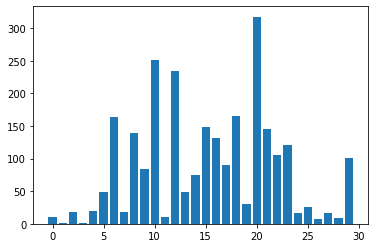

In [16]:
feature_selection_kbest(X, Y)

Hoe hoger de score des te relevanter de feature. Hieruit kunnen we concluderen dat de features:

- major axis length
- eccentricity
- euler_number

Op dit moment het meest zeggen over de labels.

door middel van de methode hebben we nu in ieder geval een begin lijst aan relevante features.

## Selection trees

[0.01453213 0.00042341 0.01630057 0.00057465 0.01849568 0.02247068
 0.06071026 0.01899039 0.0505775  0.02651662 0.06531799 0.01435473
 0.07441478 0.02421469 0.03900038 0.03802426 0.04669415 0.02688815
 0.06596336 0.03411817 0.07626585 0.04181405 0.02952269 0.04313623
 0.02048375 0.02415372 0.0165884  0.0231638  0.02173535 0.04455363]


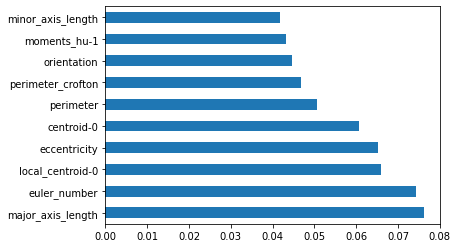

In [17]:
feature_selection_trees(X, Y)

Hier geldt eigenlijk hetzelfde. hoe hoger de score des te relevanter de feature. Hieruit blijkt dat de "major_axis_length" en de "euler_number" weer bovenuit schieten.  

## Correlation matrix

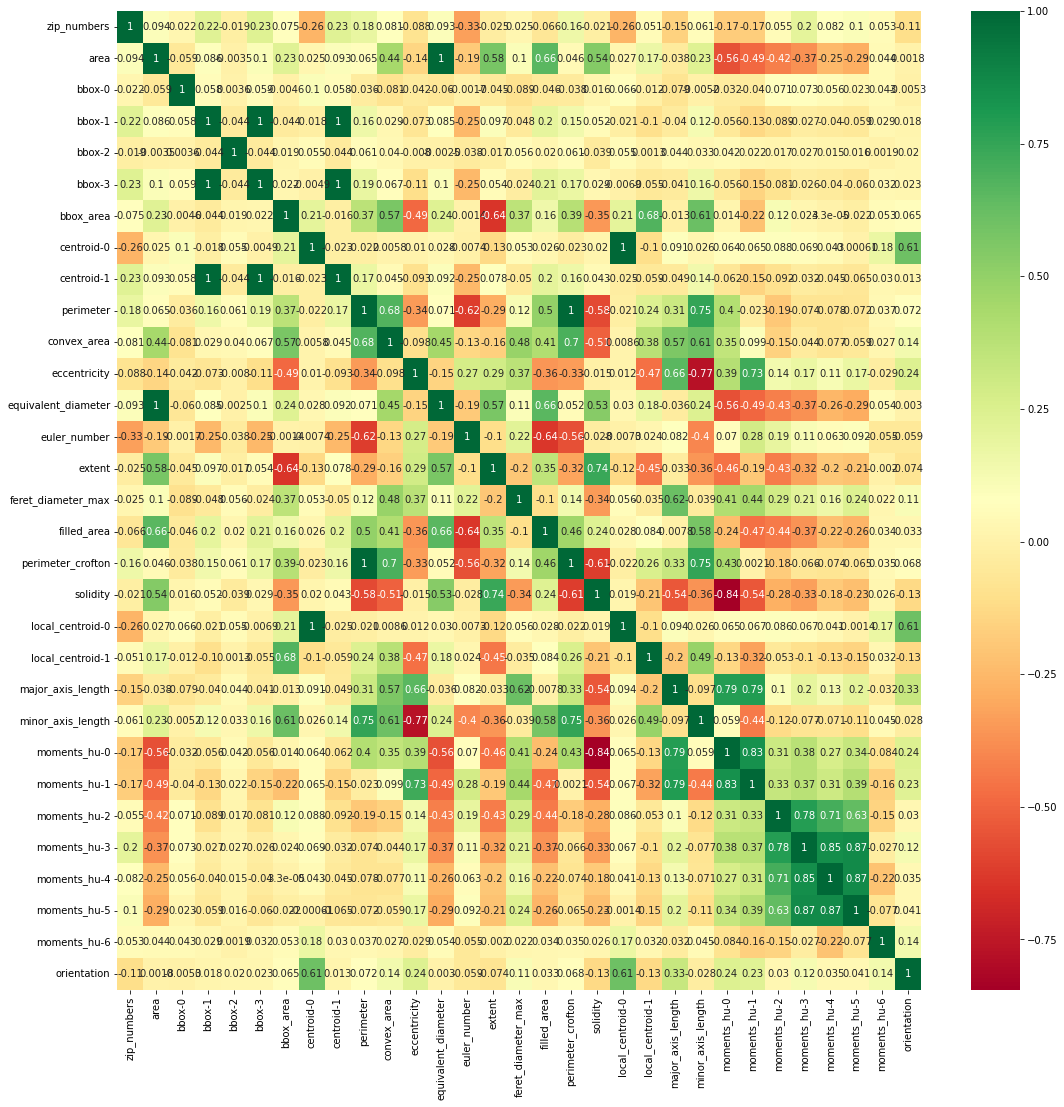

In [19]:
feature_selection_corr(result)

De Correlation matrix geeft een goed beeld over de features die relevant zijn (1) en de features die minder relevant zijn (-1). Hierbij kijken we naar het getal dat achter de "zip_numbers" staat. hier vergelijken we namelijk de feature tegenover de label.

Hieruit blijkt dat de volgende features het meest relevant zijn:

- bbox-3
- centroid-1
- bbox-1
- moments_hu4
- perimeter

Het verbaast wel dat de features die hieruit komen hoger uitspringen dan de features in de vorige methodes. Deze features zijn namelijk niet eerder voorgekomen in de hogere posities. 

# zoek meer info over dit okeeee????

In [20]:
result

,zip_numbers,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,centroid-1,perimeter,...,major_axis_length,minor_axis_length,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,orientation
0,1,287,0,6,32,26,640,15.310105,17.933798,89.840620,...,30.408628,17.616293,0.268950,0.017899,0.013183,0.000420,-2.683356e-07,-0.000042,-9.497167e-07,-0.049638
1,0,296,0,38,32,58,640,16.425676,47.395270,143.781746,...,37.565785,23.184497,0.411467,0.034031,0.001471,0.000066,-1.990600e-08,-0.000005,5.877535e-09,0.046295
2,0,300,0,70,32,91,672,16.080000,79.313333,145.781746,...,38.187484,23.086854,0.414851,0.037159,0.000701,0.000134,1.355049e-08,-0.000022,-3.859056e-08,0.131159
3,0,346,0,101,32,123,704,15.502890,111.341040,151.781746,...,38.646650,25.671956,0.388839,0.022724,0.000076,0.000091,-9.519663e-10,0.000008,7.537652e-09,0.109576
4,1,318,0,4,32,29,800,18.584906,14.393082,103.840620,...,40.612946,15.840432,0.373493,0.075548,0.010167,0.001006,-6.020065e-07,-0.000052,3.158651e-06,0.378889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2,345,0,102,32,124,704,17.214493,111.115942,120.225397,...,42.337704,18.416269,0.386167,0.069318,0.004804,0.000744,1.386400e-06,0.000195,-2.293072e-07,0.156394
956,5,279,0,7,32,24,544,14.326165,14.627240,109.396970,...,41.787009,14.656867,0.439287,0.117676,0.004865,0.001923,5.867712e-06,0.000648,4.255932e-07,0.038346
957,3,312,0,38,32,59,672,15.310897,48.391026,122.953319,...,40.042129,17.197767,0.380436,0.068613,0.003335,0.000618,-5.978847e-07,-0.000150,6.565419e-07,0.134856
958,8,431,0,69,32,92,736,16.447796,78.846868,150.994949,...,34.289232,21.607479,0.238201,0.010567,0.000232,0.000038,1.728684e-09,0.000004,3.095958e-09,0.125511


Uit de 3 bovenstaande methodes hebben we een belangrijk aantal features kunnen opstellen. Hierdoor hebben we de lijst van features kunnen inkorten. Uit nieuwsgierigheid hebben we verschillende combinaties uitgeprobeerd van deze features en de beste resultaten erbij genoteerd. 

- ['filled_area', 'bbox-3', 'perimeter', 'perimeter_crofton', 'bbox-1', 'bbox_area', 'convex_area'] -> 0.58
- ['filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'bbox-3'] -> 0.66
- ['filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent'] -> 0.69

vertel meeeeeerrrr..........................................

In [21]:
#lets select some features
# ''orientation', moments_hu-1, moments_hu-0
# filled_area, bbox-1, centroid-1, bbox_area, convex_area, bbox-3, perimeter
features = ['major_axis_length', 'minor_axis_length', 'euler_number', 'centroid-0', 'eccentricity', 'local_centroid-0', 'perimeter', 'perimeter_crofton', 'filled_area', 'orientation']
#featuresZip = ['zip_numbers', 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent']
#selected_features = result.loc[:,featuresZip]
#selected_features
# 'filled_area', 'bbox-3', 'perimeter', 'perimeter_crofton', 'bbox-1', 'bbox_area', 'convex_area' -> 0.58
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'bbox-3' -> 0.66
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'bbox-1', 'solidity', 'extent' -> 0.69/0.7
# 'filled_area', 'perimeter', 'perimeter_crofton', 'eccentricity', 'area', 'solidity', 'extent' ->

#----------------------------------------
# 'major_axis_length', 'euler_number', 'centroid-0', 'eccentricity', 'local_centroid-0', 'perimeter', 'perimeter_crofton', 'filled_area', 'bbox-1', 'centroid-1', 'bbox_area', 'convex_area', 'bbox-3'
# -> 

Na het selecteren van de features is het belangrijk om de waardes te normaliseren

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
minMaxScaler = MinMaxScaler()


def preprocess(X_train, X_test):
    print('-----Start preprocc----------')
    global features
    X_train[features] = minMaxScaler.fit_transform(X_train[features].to_numpy())
    X_test[features] = minMaxScaler.transform(X_test[features].to_numpy())
    print('---------Preprocess Done--------')
    return X_train, X_test

def splitTrainTest(result):
    # Split data into 50% train and 50% test subsets
    global features
    X_train, X_test, y_train, y_test = train_test_split(
        result[features], result['zip_numbers'], test_size=0.2, random_state=0)
    
    X_train, X_test = preprocess(X_train, X_test)
    return X_train, X_test, y_train, y_test

Na het normaliseren zullen we de data splitten tussen in train en test data.

In [25]:
X_train, X_test, y_train, y_test = splitTrainTest(result)

-----Start preprocc----------
---------Preprocess Done--------


## Trainen / Testen / Evalueren

Inmiddels hebben we de data verzameld. We hebben de data geanalyseerd en de benodigde features eruit gehaald. De preprocessors staan ook klaar. Dit betekent dat we door kunnen gaan met het uitkiezen van de bijpassende algoritme.

Omdat er meerdere algoritmes bestaan willen we graag de algoritme kiezen met de hoogste accuracy. Hiervoor zijn de volgende regels belangrijk:

- Verschillende parameters gebruiken per algoritme om de hoogst mogelijke accuraatheid te halen.
- Algoritme controleren op overfitting en underfitting

Voor het testen van de algoritmes met verschillende parameters zullen we gebruik maken van Grid search. Hiermee kunnen we een lijst meegeven van parameters. De functie zal dan deze lijst aflopen en de parameters die de hoogste accuraatheid halen tonen.

Om de algoritme te controleren op overfitting en underfitting zullen we gebruik maken van Kfolding.

We zullen de resultaten vergelijken tussen de volgende algoritmes:

- KNN
- Gaussian NB
- SVC
- Decision Tree
- Random Forest

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [27]:
def knn_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='chebyshev')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_knn(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = knn_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def searchHyperParams_knn(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'n_neighbors' : [3,5,11,14,19],
        'weights' : ['uniform', 'distance'],
        'metric' : ['euclidean', 'manhattan', 'chebyshev']
    }

    gs = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def gaussian_nb_fit_score(result):
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    score = gnb.score(X_test, y_test)
    print(score)
    
def searchHyperParams_svc(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'C': [0.1,1, 10, 100],
        'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1,0.1,0.01,0.001]
    }

    gs = GridSearchCV(
        SVC(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)
    
def searchHyperParams_DT(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'criterion': ['gini', 'entropy'],
        'splitter' : ['best', 'random'],
        'max_depth': [1,5,10,20,50,100,150,None],
        'min_samples_split': np.arange(2,5),
        'min_samples_leaf': np.arange(1,5),
        'min_weight_fraction_leaf': np.arange(0,0.5)
    }

    gs = GridSearchCV(
        DecisionTreeClassifier(),
        grid_params,
        verbose = 1,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

def searchHyperParams_RC(result):
    print('--------start searching params--------')
    X_train, X_test, y_train, y_test = splitTrainTest(result)
    print('--------splitted train test----------')
    grid_params = {
        'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800]
    }

    gs = GridSearchCV(
        RandomForestClassifier(),
        grid_params,
        verbose = 3,
        cv = 3,
        n_jobs = -1
    )
    print('---------grid search started---------')
    gs_results = gs.fit(X_train, y_train)

    print('--------Done--------')
    print('best score:')
    print(gs_results.best_score_)
    print('best estimator:')
    print(gs_results.best_estimator_)
    print('best params:')
    print(gs_results.best_params_)

In [28]:
searchHyperParams_knn(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 30 candidates, totalling 90 fits
--------Done--------
best score:
0.8359375
best estimator:
KNeighborsClassifier(metric='chebyshev', weights='distance')
best params:
{'metric': 'chebyshev', 'n_neighbors': 5, 'weights': 'distance'}


In [29]:
gaussian_nb_fit_score(result)

-----Start preprocc----------
---------Preprocess Done--------
0.65625


In [30]:
searchHyperParams_svc(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 64 candidates, totalling 192 fits
--------Done--------
best score:
0.8450520833333334
best estimator:
SVC(C=1, gamma=1, kernel='poly')
best params:
{'C': 1, 'gamma': 1, 'kernel': 'poly'}


In [31]:
searchHyperParams_DT(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 384 candidates, totalling 1152 fits
--------Done--------
best score:
0.7630208333333334
best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=4, splitter='random')
best params:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}


In [32]:
searchHyperParams_RC(result)

--------start searching params--------
-----Start preprocc----------
---------Preprocess Done--------
--------splitted train test----------
---------grid search started---------
Fitting 3 folds for each of 720 candidates, totalling 2160 fits
--------Done--------
best score:
0.8268229166666666
best estimator:
RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)
best params:
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [33]:
def knn_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='chebyshev')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_knn(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = knn_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def svc_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = SVC(C=1, gamma=1, kernel='poly')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_svc(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = svc_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def DT_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=4, splitter='random')
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_DT(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = DT_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1
        
def RN_fit_score(X_train, X_test, y_train, y_test):
    train_samples = len(X_train)
    test_samples = len (X_test)
    neigh = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200)
    neigh.fit(X_train, y_train.to_numpy().reshape(train_samples))

    score = neigh.score(X_test, y_test.to_numpy().reshape(test_samples))
    return score

def kfolding_RN(dataset):
    kf = KFold(n_splits=5, shuffle=True)
    global features
    X_training = dataset[features]
    y_training = dataset['zip_numbers']
    k = 1
    for train_index, test_index in kf.split(X_training, y_training):
        
        X_train, X_test = X_training.loc[train_index,:], X_training.loc[test_index,:]
        y_train, y_test = y_training.loc[train_index], y_training.loc[test_index]
        X_train, X_test = preprocess(X_train, X_test)
        
        score = RN_fit_score(X_train, X_test, y_train, y_test)
        print("[fold {0}], score: {1:.5f}".
          format(k, score))
        k = k + 1

In [34]:
kfolding_knn(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.83854
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.88021
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.76562
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.83854
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.85417


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

In [35]:
kfolding_svc(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.83333
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.82812
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.84896
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.85938
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.83333


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

In [36]:
kfolding_DT(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.76562
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.78646
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.73438
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.68750
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.73438


Uit de resultaten kunnen we concluderen dat de algoritme als nog hetzelfde presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting. Maar nog wel de benodigde data, preprocessing of features mist om goed te kunnen presteren.

In [37]:
kfolding_RN(result)

-----Start preprocc----------
---------Preprocess Done--------
[fold 1], score: 0.81250
-----Start preprocc----------
---------Preprocess Done--------
[fold 2], score: 0.80729
-----Start preprocc----------
---------Preprocess Done--------
[fold 3], score: 0.81771
-----Start preprocc----------
---------Preprocess Done--------
[fold 4], score: 0.82292
-----Start preprocc----------
---------Preprocess Done--------
[fold 5], score: 0.85417


Uit de resultaten kunnen we concluderen dat de algoritme als nog goed presteert onder de kfolding methode. Dit betekent dat de model geen last heeft van zowel overfitting als underfitting.

## Resultaten

ALGORITME LATEN WERKEN VOORSPELLEN ZIPS

## Conclusie

Het lijkt erop conclusie jowww

In [ ]:
# models seems ok. lets combine both features to clear or set